In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer

import nltk  as nltk

from gensim.utils import lemmatize

import appos
appos = appos.appos

from keras.models import Sequential



ModuleNotFoundError: No module named 'appos'

In [ ]:
data = pd.read_csv('citation_sentiment_corpus.txt', sep="\t", header=None)
data.columns = ["Source_Paper_ID", "Target_Paper_ID", "Sentiment", "Citation_Text"]
data.tail()

### Drop duplicates

In [159]:
print ("Original:", data.shape)
data = data.drop_duplicates()
data = data.reset_index(drop=True)
print ("Drop Dupicates:", data.shape)


Original: (8734, 4)
Drop Dupicates: (8734, 4)


## Preprocessing
Preprocessing data can consist of many steps depending on the data and the situation
#### Tokenization
Tokenization is the process of converting text into tokens before transforming it into vectors. It is also easier to filter out unnecessary tokens. For example, a document into paragraphs or sentences into words. In this case we are tokenising the reviews into words.

#### Stopwords
Stop words are the most commonly occuring words which are not relevant in the context of the data and do not contribute any deeper meaning to the phrase. In this case contain no sentiment. NLTK provide a library used for this.

#### Normalization 
Words which look different due to casing or written another way but are the same in meaning need to be process correctly. Normalisation processes ensure that these words are treated equally. For example, changing numbers to their word equivalents or converting the casing of all the text.
1. Casing the Characters
Converting character to the same case so the same words are recognised as the same. In this case we converted to lowercase.
2. Negation handling
Apostrophes connecting words are used everywhere, especially in public reviews. To maintain uniform structure it is recommended they should be converted into standard lexicons. The text will then follow the rules of context free grammar and helps avoids any word-sense disambiguation.
3. Removing punctuations, special characters and numerical tokens 
Stand alone punctuations, special characters and numerical tokens are removed as they do not contribute to sentiment which leaves only alphabetic characters. This step needs the use of tokenized words as they have been split appropriately for us to remove.
tokens
4.  Lemmatization
This process finds the base or dictionary form of the word known as the lemma. This is done through the use of vocabulary (dictionary importance of words) and morphological analysis (word structure and grammar relations). This normalization is similar to stemming but takes into account the context of the word.

In [145]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
def lemmatize(cite_text):
    result = []
    for text in cite_text.values:
        
        #Lowercasing before negation
        lower_case = text.lower()
        #Lemmatization
        lemm = lemmatizer.lemmatize(lower_case)
        result.append(lemm)
        
    return result

def part_of_speech_tagging(cite_text):
    result = []
    for text in cite_text.values:
        
        #Lowercasing before negation
        lower_case = text.lower()
        #Lemmatization
        pos = nltk.pos_tag(nltk.word_tokenize(lower_case))
        result.append(pos)
        
    return result

data['lemmatized_text']= lemmatize(data['Citation_Text'])

data['pos_tags']= part_of_speech_tagging(data['Citation_Text'])

data.head()

,Source_Paper_ID,Target_Paper_ID,Sentiment,Citation_Text,lemmatized_text,pos_tags
0,A00-1043,A00-2024,o,We analyzed a set of articles and identified s...,we analyzed a set of articles and identified s...,"[(we, PRP), (analyzed, VBD), (a, DT), (set, NN..."
1,H05-1033,A00-2024,o,Table 3: Example compressions Compression AvgL...,table 3: example compressions compression avgl...,"[(table, JJ), (3, CD), (:, :), (example, NN), ..."
2,I05-2009,A00-2024,o,5.3 Related works and discussion Our two-step ...,5.3 related works and discussion our two-step ...,"[(5.3, CD), (related, JJ), (works, NNS), (and,..."
3,I05-2009,A00-2024,o,(1999) proposed a summarization system based o...,(1999) proposed a summarization system based o...,"[((, (), (1999, CD), (), )), (proposed, VBD), ..."
4,I05-2009,A00-2024,o,We found that the deletion of lead parts did n...,we found that the deletion of lead parts did n...,"[(we, PRP), (found, VBD), (that, IN), (the, DT..."


### K fold cross validation
we split our data into k subsets, and train on k-1 one of those subset. 

In [140]:
from sklearn.model_selection import KFold 
X = df['Citation_Text']
Y = df['Sentiment']
kfold = KFold(n_splits=5, random_state=1, shuffle=True)

kfold


KFold(n_splits=5, random_state=1, shuffle=True)

## LSTM

In [160]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#data['encoded_text'] = [x.encode('ascii') for x in data['Citation_Text']]
#data['text'] = [x.encode('ascii') for x in data['Citation_Text']]

tokenizer = Tokenizer(nb_words=200, lower=True,split=' ')
tokenizer.fit_on_texts(data['Citation_Text'].values)
#print(tokenizer.word_index)  # To see the dicstionary
X = tokenizer.texts_to_sequences(data['Citation_Text'].values)
X = pad_sequences(X)
Y = pd.get_dummies(df['Sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7860, 2336) (7860, 3)
(874, 2336) (874, 3)


In [161]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 2336, 100)         5000000   
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 2336, 100)         0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 303       
Total params: 5,080,703
Trainable params: 5,080,703
Non-trainable params: 0
_________________________________________________________________
None


In [162]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7074 samples, validate on 786 samples
Epoch 1/5
7074/7074 [==============================] - 550s 78ms/step - loss: 0.5060 - accuracy: 0.8694 - val_loss: 0.3940 - val_accuracy: 0.8931
Epoch 2/5
7074/7074 [==============================] - 563s 80ms/step - loss: 0.4326 - accuracy: 0.8745 - val_loss: 0.3786 - val_accuracy: 0.8931
Epoch 3/5
7074/7074 [==============================] - 638s 90ms/step - loss: 0.4122 - accuracy: 0.8746 - val_loss: 0.3647 - val_accuracy: 0.8944
Epoch 4/5
7074/7074 [==============================] - 514s 73ms/step - loss: 0.4005 - accuracy: 0.8745 - val_loss: 0.3704 - val_accuracy: 0.8957
Epoch 5/5
7074/7074 [==============================] - 419s 59ms/step - loss: 0.3960 - accuracy: 0.8753 - val_loss: 0.3685 - val_accuracy: 0.8944


In [ ]:
scores = model.evaluate(X, y, verbose=0)
print("Model Accuracy: %.2f%%" % (scores[1]*100))

In [179]:
y_pred = model.predict(X_test)
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))

matrix


array([[  0,  30,   1],
       [  1, 736,   1],
       [  0, 103,   2]])

In [186]:
metrics.accuracy_score(Y_test.argmax(axis=1), y_pred.argmax(axis=1))

0.8443935926773455

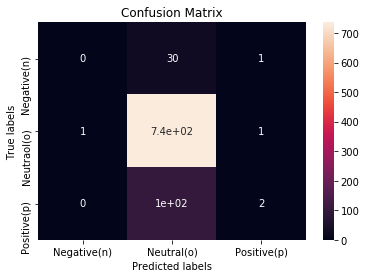

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(["Negative(n)", "Neutral(o)", "Positive(p)"]); ax.yaxis.set_ticklabels(["Negative(n)", "Neutraol(o)", "Positive(p)"]);

In [ ]:
,labels=["Negative(n)", "Neutraol(o)", "Positive(p)"

In [184]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

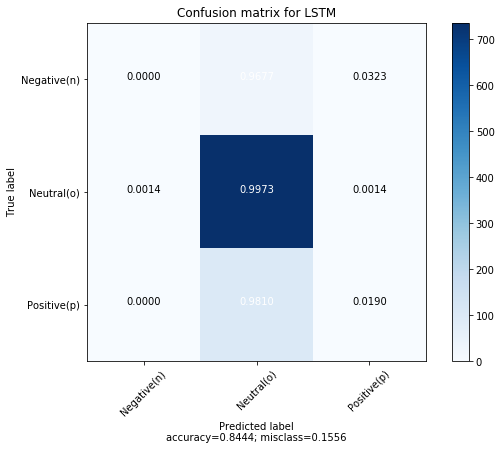

In [189]:
target_names = ["Negative(n)", "Neutral(o)", "Positive(p)"]
plot_confusion_matrix(matrix,
                          target_names,
                          title='Confusion matrix for LSTM',
                          cmap=None,
                          normalize=True)